## Занятие 8. Поиск ключевых точек и сопоставление изображений
#### Часть 1. Проективные отображения

In [243]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 20]

Text(0.5, 1.0, 'Bird frontal example (1)')

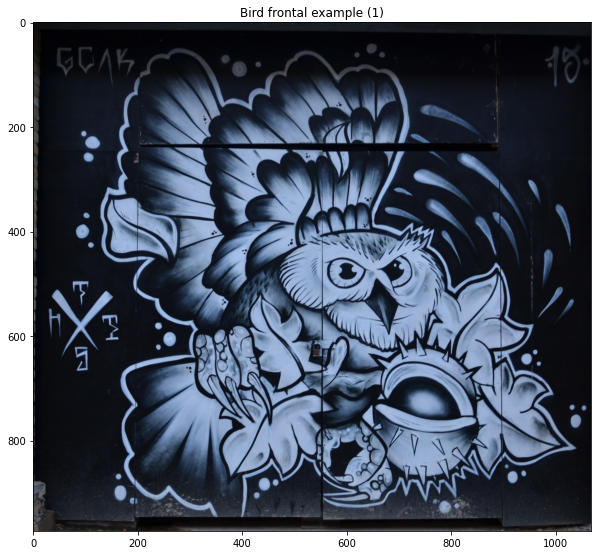

In [193]:
img1 = plt.imread(Path() / 'hpatches_tiny'/'v_bird'/'1.ppm')
plt.imshow(
    img1
)
plt.title("Bird frontal example (1)")

(973, 1068, 3) (653, 986, 3)


Text(0.5, 1.0, 'Bird projected examples (4, 2)')

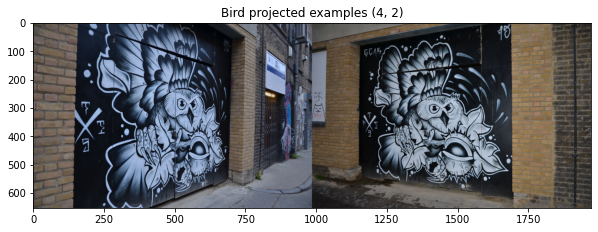

In [195]:
img2 = plt.imread(Path() / 'hpatches_tiny'/'v_bird'/'2.ppm')
img4 = plt.imread(Path() / 'hpatches_tiny'/'v_bird'/'4.ppm')

print(img1.shape, img2.shape)

plt.imshow(
    np.concatenate((img4, img2), axis=1)
)
plt.title("Bird projected examples (4, 2)")

### Афинное преобразование
$ y = Ax +b $

#### Вопрос: Можно ли получить фронтальное изображение (1) из спроецированных (4, 2) с помощью афинного преобразования? 

In [197]:
def dumb_affine_transform(img, affine_matrix, affine_bias):
    A = affine_matrix
    B = affine_bias
    
    img_new = np.zeros_like(img)
    h, w, _ = img.shape
    # Для всех пикселов
    for y in range(h):
        for x in range(w):
            # определяем, куда должен аффинно отобразиться пиксел
            yx = A @ np.array([y, x]) + B

            # округляем и обрезаем новый индекс пиксела
            y_n, x_n = yx.round().astype(int)
            
            if not (0 <= y_n < h-1):
                continue
            if not (0 <= x_n < w-1):
                continue
            # отображаем пиксел
            img_new[y_n, x_n] = img[y, x]
    return img_new

In [198]:
# Матрица вращения для 2D, определяемая углом

def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], 
                     [np.sin(theta),  np.cos(theta)]])
rotation_matrix(np.pi/4)

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [199]:
# Подготовим изображение - сожмем его и добавим красную рамку

def red_border(img_src, border=2):
    b = border
    img = img_src.copy()
    img[:b, :, :] = np.array([255, 0, 0])
    img[-b:, :, :] = np.array([255, 0, 0])
    img[:, :b, :] = np.array([255, 0, 0])
    img[:, -b:, :] = np.array([255, 0, 0])
    return img

img_r = red_border(img1[::5, ::5])


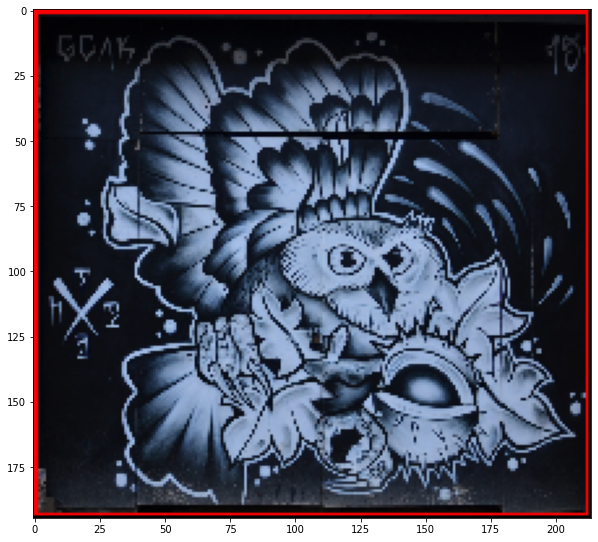

In [200]:

plt.imshow(dumb_affine_transform(
    img_r,
    np.eye(2), 
    np.zeros(2)
))

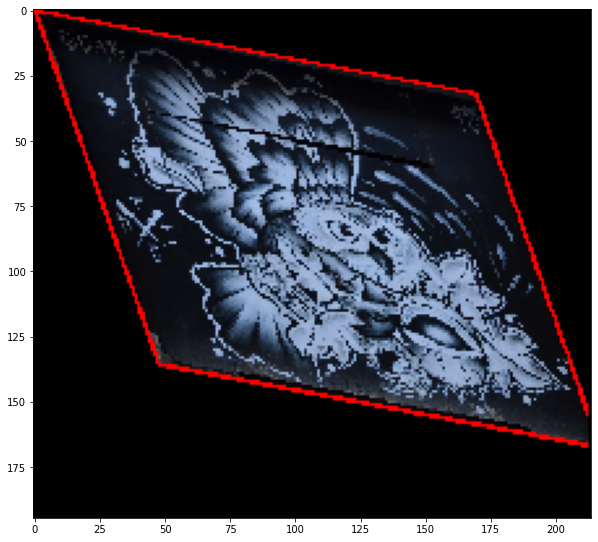

In [214]:
plt.imshow(dumb_affine_transform(
    img_r,
    np.eye(2) + np.random.randn(2, 2) / 3,
    np.random.randn(1)
))

Аффинные отображения: переводят параллельные прямые в параллельные прямые.

Проективные отображения: переводят прямые в прямые. 


## Проективное отображение
#### Смотри [Multiple View Geometry In Computer Vision](https://github.com/DeepRobot2020/books/blob/master/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf)

Проективное отображение в 2D - определяется матрицей вида:

$$ 
\begin{pmatrix}
p_{11} & p_{12} & p_{13}\\
p_{21} & p_{22} & p_{23}\\
p_{31} & p_{32} & 1_{33}
\end{pmatrix} 
$$

Матрица (3 х 3) - применяется к вектору 2D в гомогенных координатах:
$$
\begin{bmatrix}
x\\
y
\end{bmatrix}
\leftrightarrow
\begin{pmatrix}
x\\
y\\
1
\end{pmatrix}
\equiv
\begin{pmatrix}
C \cdot x\\
C \cdot y\\
C
\end{pmatrix}
$$


Значения в гомогенных координатах вида 
$$
\begin{pmatrix}
x\\
y\\
0
\end{pmatrix}
$$
не соответствуют реальным точкам, а соответствуют "точке на бесконечности по направлению $(x y)$"

Пример:

$$ 
\begin{pmatrix}
p_{11} & p_{12} & p_{13}\\
p_{21} & p_{22} & p_{23}\\
p_{31} & p_{32} & 1_{33}
\end{pmatrix} 
\begin{pmatrix}
x\\
y\\
1
\end{pmatrix}
=
\begin{pmatrix} 
p_{11}x + p_{12}y + p_{13}\\
p_{21}x + p_{22}y + p_{23}\\
p_{31}x + p_{32}y + 1
\end{pmatrix}
=
\begin{pmatrix}
\hat{C}\hat{x}\\
\hat{C}\hat{y}\\
\hat{C}
\end{pmatrix}
$$



$$ 
\begin{pmatrix}
\hat{x}\\
\hat{y}\\
1
\end{pmatrix}
=
\begin{pmatrix} 
\frac{p_{11}x + p_{12}y + p_{13}}{p_{31}x + p_{32}y + 1}\\
\frac{p_{21}x + p_{22}y + p_{23}}{p_{31}x + p_{32}y + 1}\\
1
\end{pmatrix}
$$

Матрица P проецирует точку $(x, y)$ в  $( \hat{x}, \hat{y})$


В общем случае проекция, очевидно, - неаффиинное преобразование.

## Вопрос: В каких частных случаях проективное преобразование станет афинным?

### Задача-0. Напишите проективное преобразование.

In [ ]:
def dumb_projective_transform(img, projective_matrix):
    P = projective_matrix

    img_new = np.zeros_like(img)
    h, w, _ = img.shape
    
    # Для всех пикселов
    for y in range(h):
        for x in range(w):
            # определяем, куда должен проективно отобразиться пиксел?
            y_n = None
            x_n = None
            if not (0 <= y_n < h-1):
                continue
            if not (0 <= x_n < w-1):
                continue
            # отображаем пиксел
            img_new[y_n, x_n] = img[y, x]
    return img_new

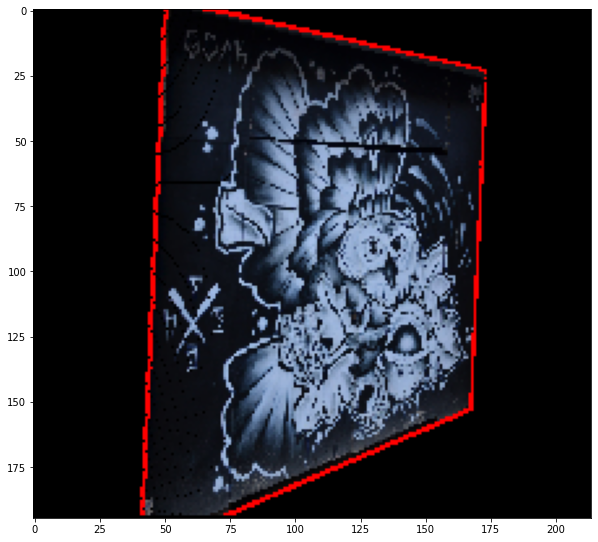

In [232]:
# Итеративно подобранная проективная матрица
plt.imshow(dumb_projective_transform(
    img_r,
    np.array([
        [1.1, 0.2, -5],
        [-0.05, 1.1, 50],
        [0., 0.003, 1]
    ])
))

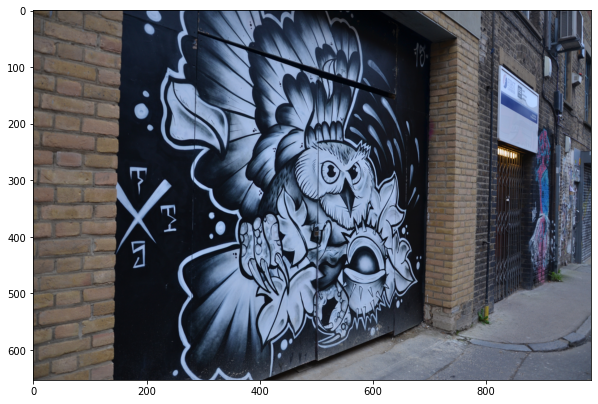

In [233]:
plt.imshow(img4)

## Проективная модель камеры
Смотри [документацию OpenCV](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)

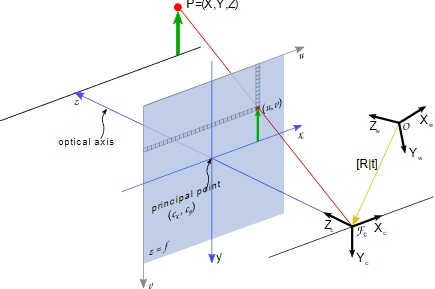

In [234]:
from IPython.display import Image
Image(Path()/'data' / 'camera.jpg', width=800)


## Внутренние параметры камеры (intrinsics)
Проекция пространства предметов в собственной системе координат камеры в пространство изображения определяется внутренними характеристиками камеры.

$$
\begin{pmatrix}
u\\
v\\
1
\end{pmatrix}
=
\begin{pmatrix}
f_x, 0, c_x\\
0, f_y, c_y\\
0, 0, 1
\end{pmatrix}
\cdot
\begin{pmatrix}
X_c\\
Y_c\\
Z_c
\end{pmatrix}
=
K_{33} \cdot 
\begin{pmatrix}
X_c\\
Y_c\\
Z_c
\end{pmatrix}
$$
$$
\begin{pmatrix}
u\\
v\\
1
\end{pmatrix}
=
\begin{pmatrix}
k_{11}, k_{12}, k_{13}, 0\\
k_{21}, k_{22}, k_{23}, 0\\
k_{31}, k_{32}, k_{33}, 0\\
\end{pmatrix}
\cdot
\begin{pmatrix}
X_c\\
Y_c\\
Z_c\\
1
\end{pmatrix}
$$

- f_x, f_y - фокусные расстояния по Х и У
- с_x, c_y - положение principal point - точки пересечения оптической оси с плоскостью изображения


## Вопрос: почему вдруг фокусные расстояния для X и Y - разные?

## Внешние параметры камеры (extrinsics)
Обычно положение предметов можно измерить не в собственной системе координат камеры, а в некоторой "мировой" системе координат.

Связь "Мировой" и "собственной" системы координат определяется положением камеры:
- вектором переноса T 
- матрица вращения R

$$
\begin{pmatrix}
X_c\\
Y_c\\
Z_c \\
1
\end{pmatrix}
=
\begin{bmatrix}
R_{33}, T_{13}\\
0,  1\\
\end{bmatrix}
\begin{pmatrix}
X_w\\
Y_w\\
Z_w \\
1
\end{pmatrix}
\equiv
R \cdot 
\begin{pmatrix}
X_w\\
Y_w\\
Z_w \\
\end{pmatrix} + T
$$


## Intrinsic + Extrinsic
Камера проецирует гомогенные 3D мировые координаты в гомомогенные 2D пиксел-координаты

$$
\begin{pmatrix}
u\\
v\\
1
\end{pmatrix}
= P_{43}(K, R, T) \cdot 
\begin{pmatrix}
X_w\\
Y_w\\
Z_w \\
1
\end{pmatrix}
$$

Фотографии одной камерой с разных ракурсов отличаются только Extrinsic.

## Воспользуемся разметкой HPatchs
В HPatches есть разметка - истиные матрицы проективного преобразования между изображениями

In [235]:
def read_hpatches_projection_matrix(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    values = []
    for l in lines:
        values.append([float(v) for v in l.split(' ')])
    return np.array(values)

mtx_14 = read_hpatches_projection_matrix(Path() / 'hpatches_tiny'/ 'v_bird' / 'H_1_4')
mtx_14

array([[ 1.2869e+00, -3.5671e-03,  9.0117e+01],
       [ 3.4981e-01,  1.1421e+00, -2.9048e+02],
       [ 1.0338e-03,  2.5575e-05,  9.9928e-01]])

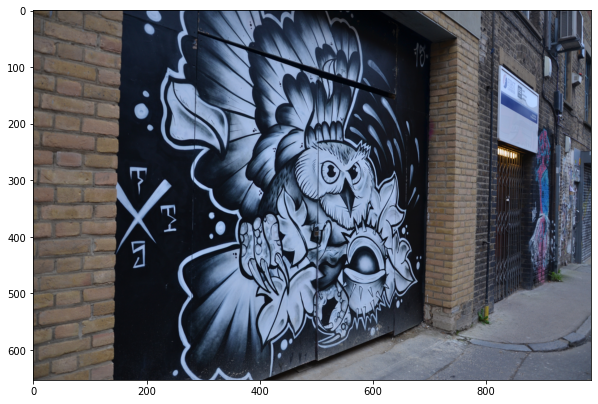

In [236]:
plt.imshow(img4)

Text(0.5, 1.0, '1 to 4')

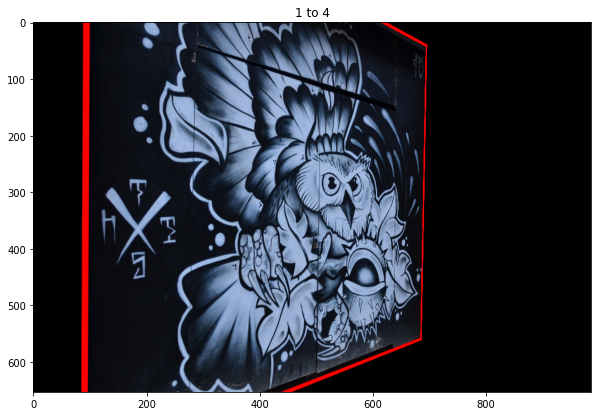

In [237]:
import cv2
plt.imshow(cv2.warpPerspective(red_border(img1, border=10), mtx_14, dsize=(img4.shape[1], img4.shape[0])))
plt.title("1 to 4")

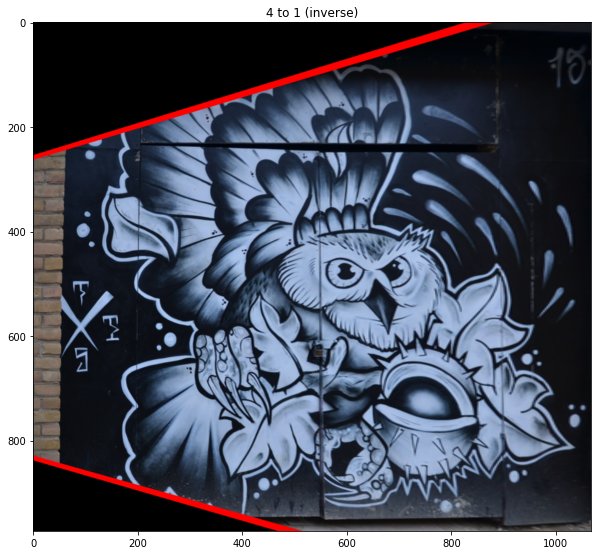

In [238]:
plt.title("4 to 1 (inverse)")
plt.imshow(cv2.warpPerspective(red_border(img4, border=10), np.linalg.inv(mtx_14), dsize=(img1.shape[1], img1.shape[0])))

## Задача-1. Цепочка отображений
Отобразите изображение 2 в изображение 4

Text(0.5, 1.0, 'Bird projected examples (4, 2)')

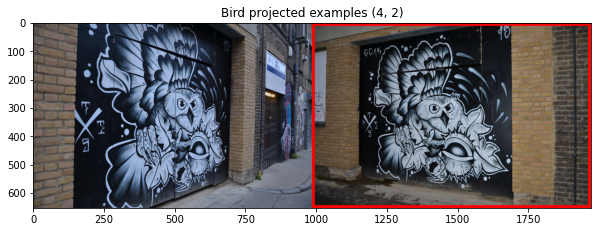

In [244]:
mtx_14 = read_hpatches_projection_matrix(Path() / 'hpatches_tiny'/ 'v_bird' / 'H_1_4')
mtx_12 = read_hpatches_projection_matrix(Path() / 'hpatches_tiny'/ 'v_bird' / 'H_1_2')
plt.imshow(
    np.concatenate((img4, red_border(img2, border=10)), axis=1)
)
plt.title("Bird projected examples (4, 2)")

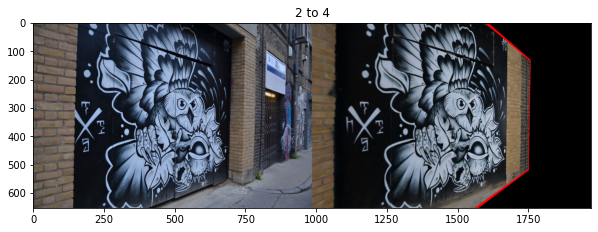

In [246]:
plt.title("2 to 4")
img2r = red_border(img2, border=10)

# YOUR CODE HERE

plt.imshow(
    np.concatenate((img4, img2_to_4), axis=1)
)

# Итого
1. Проекции отображают прямые в прямые (и плоскостей - в плоскости)
2. Камера (в pinhole приближении) осуществляет проекцию предметов на экран
3. С помощью проективных отображений (матрицы 3х3) можно "изменять" ракурс (выполнять image matching)